In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns

from theano import shared

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
import sys, IPython, scipy, matplotlib, pandas, seaborn, patsy, platform, theano
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nPandas {}\nSeaborn {}\nPatsy {}\nMatplotlib {}\nTheano {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, pandas.__version__, seaborn.__version__, patsy.__version__, matplotlib.__version__, theano.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.8
ArviZ 0.7.0
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Seaborn 0.10.0
Patsy 0.5.1
Matplotlib 3.2.1
Theano 1.0.4



# Chapter 6 The Haunted DAG & The Causal Terror

### Code 6.1

In [4]:
# num grant proposals
N = 200
# proportion to select
p = 0.1 
# uncorrelated newsworthiness and trustworthiness 
nw = stats.norm().rvs(N)
tw = stats.norm().rvs(N)
# select top 10% of combined scores
s = nw+tw #totalscore
# top 10% threshold selected
q = np.quantile(s, 1-p)
selected = s>=q
# calculate correlation between newsworthiness and trustworthiness 
np.corrcoef(tw[selected], nw[selected])

array([[ 1.        , -0.67012723],
       [-0.67012723,  1.        ]])

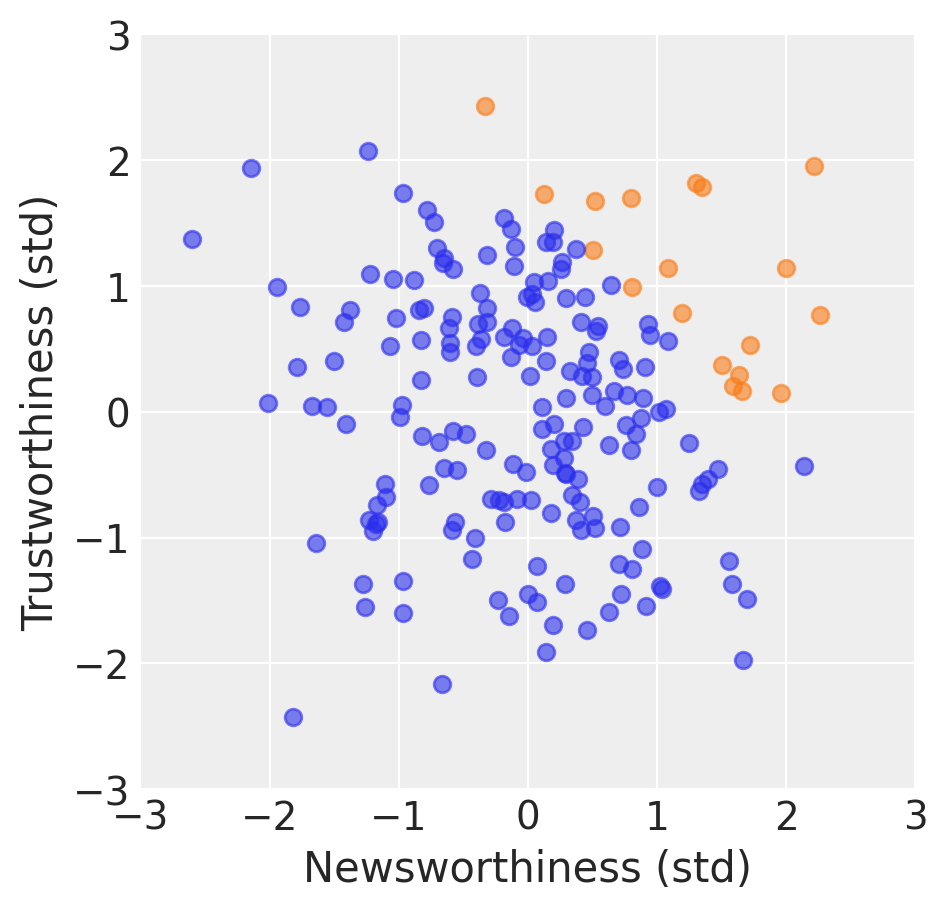

In [5]:
# plot results
fig = plt.figure(figsize=(5, 5))
# selected
plt.plot(nw[selected], tw[selected], "C1o", alpha=0.6)
# not selected
plt.plot(nw[~selected], tw[~selected], "C0o", alpha=0.6)
plt.ylabel('Trustworthiness (std)', fontsize=15)
plt.xlabel('Newsworthiness (std)', fontsize=15)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

## 6.1. Multicollinearity

### 6.1.1. Multicollinear legs

### Code 6.2

In [6]:
# number of individuals
N = 100
# sim total height of each
height = stats.norm.rvs(size=N, loc=10, scale=2)
# leg as proportion of height
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.5) 
# sim left leg as proportion + error
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
# sim right leg as proportion + error
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
# combine into data frame
d = {'Height': height, 'Leg_Left': leg_left, 'Leg_Right': leg_right}
df = pd.DataFrame(data=d)
df.head()

,Height,Leg_Left,Leg_Right
0,6.483628,3.884659,3.878910
1,11.053418,4.729281,4.726189
2,11.737025,6.858117,6.879794
3,7.463715,4.883618,4.909127
4,12.437168,5.984713,5.952625


### Code 6.3

In [7]:
# define model: height ~ leg_left + leg_right
with pm.Model() as m6_1:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Normal('br', mu=2, sd=10)
    sigma = pm.Exponential('sigma', 1)
    #sigma = pm.Uniform('sigma', lower=0 , upper=10)
    mu = pm.Deterministic('mu', a + bl*df['Leg_Left'] + br*df['Leg_Right'])
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df['Height'])
    m6_1_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, br, bl, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [02:49<00:00, 47.13draws/s] 


In [8]:
# show model summary
varnames = ['~mu']
az.summary(m6_1_trace, varnames, kind="stats", round_to=2)

,mean,sd,hpd_3%,hpd_97%
a,5.70,0.49,4.71,6.53
bl,-1.98,3.98,-9.89,5.07
br,2.66,3.99,-4.38,10.59
sigma,1.47,0.10,1.28,1.67


### Code 6.4

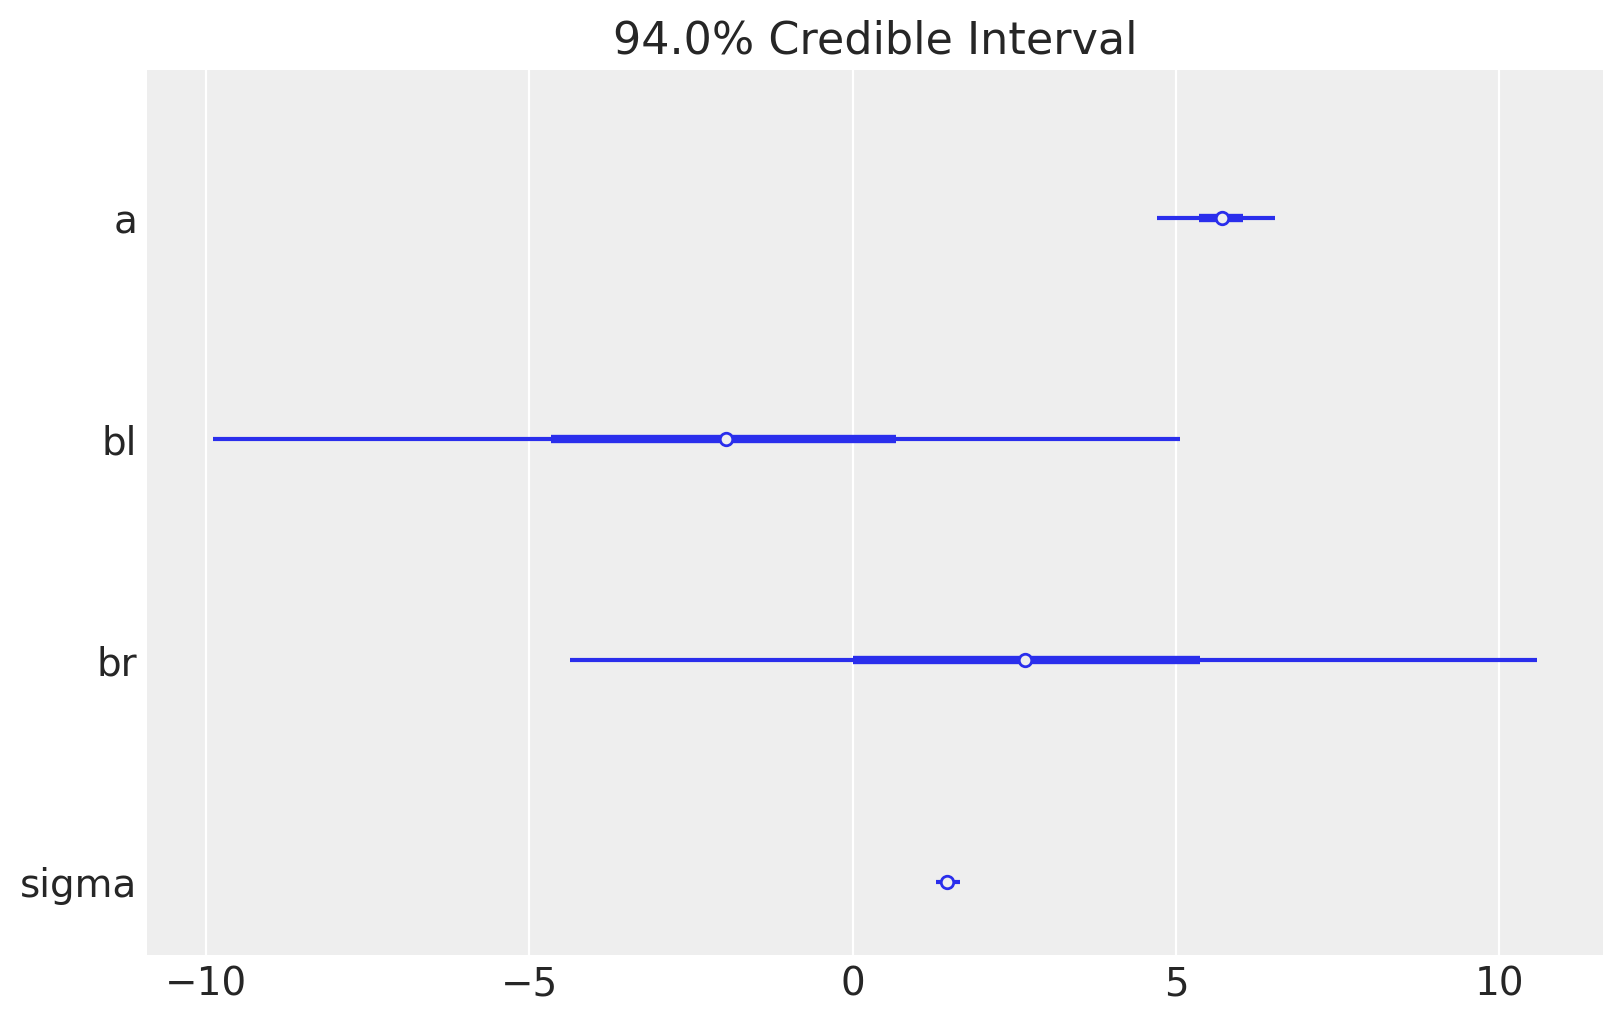

In [9]:
# plot results
axes = az.plot_forest(
    m6_1_trace,
    kind='forestplot',
    var_names=['a','bl','br','sigma'],
    combined=True,
    ridgeplot_overlap=3,
    credible_interval=0.94,
    figsize=(8, 5))

### Code 6.5

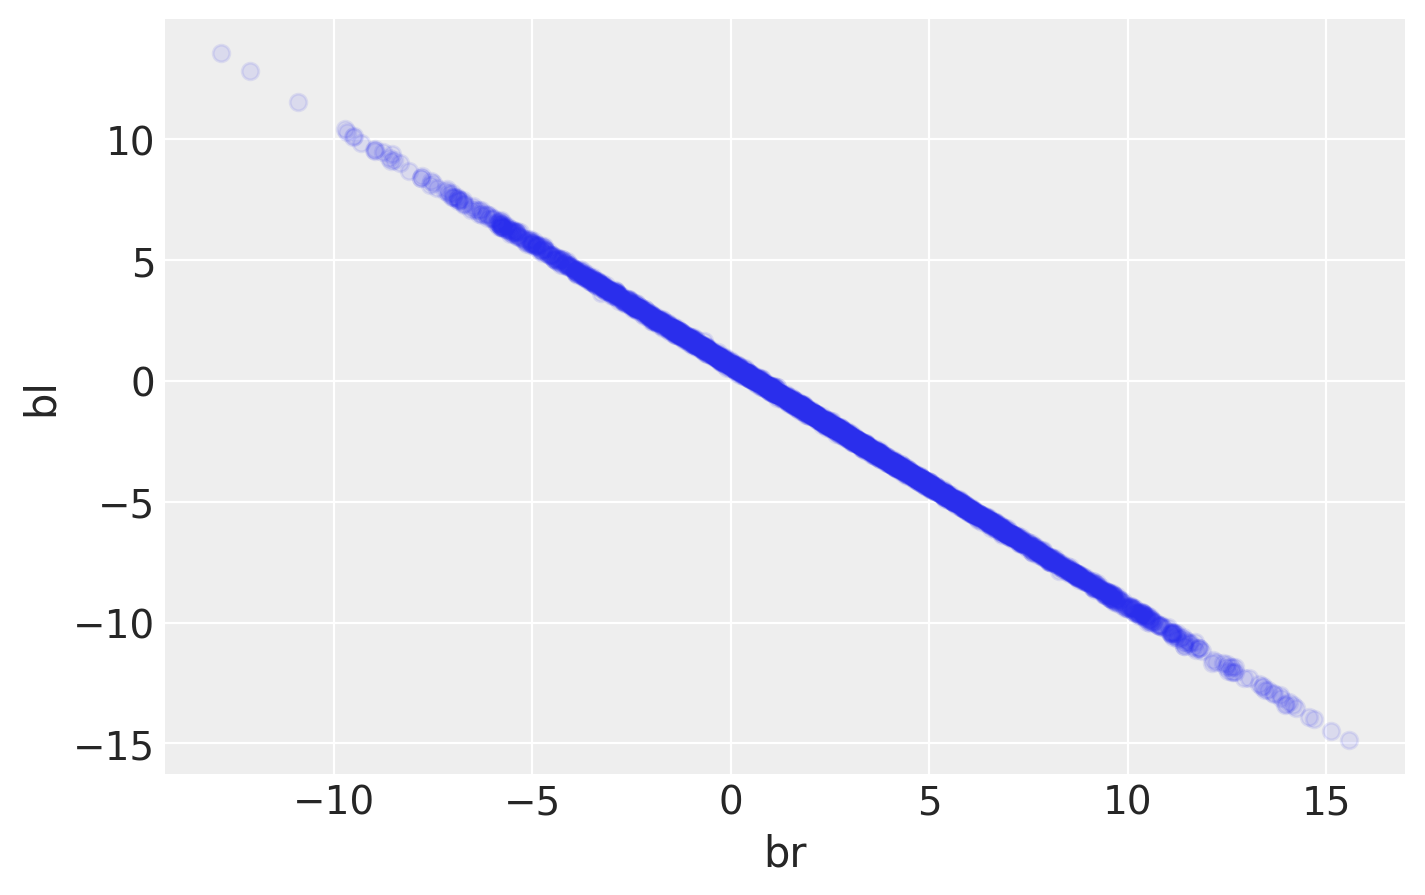

In [10]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(m6_1_trace['br'], m6_1_trace['bl'], 'o', alpha=0.1)
plt.ylabel('bl', fontsize=15)
plt.xlabel('br', fontsize=15)
plt.show()

### Code 6.6

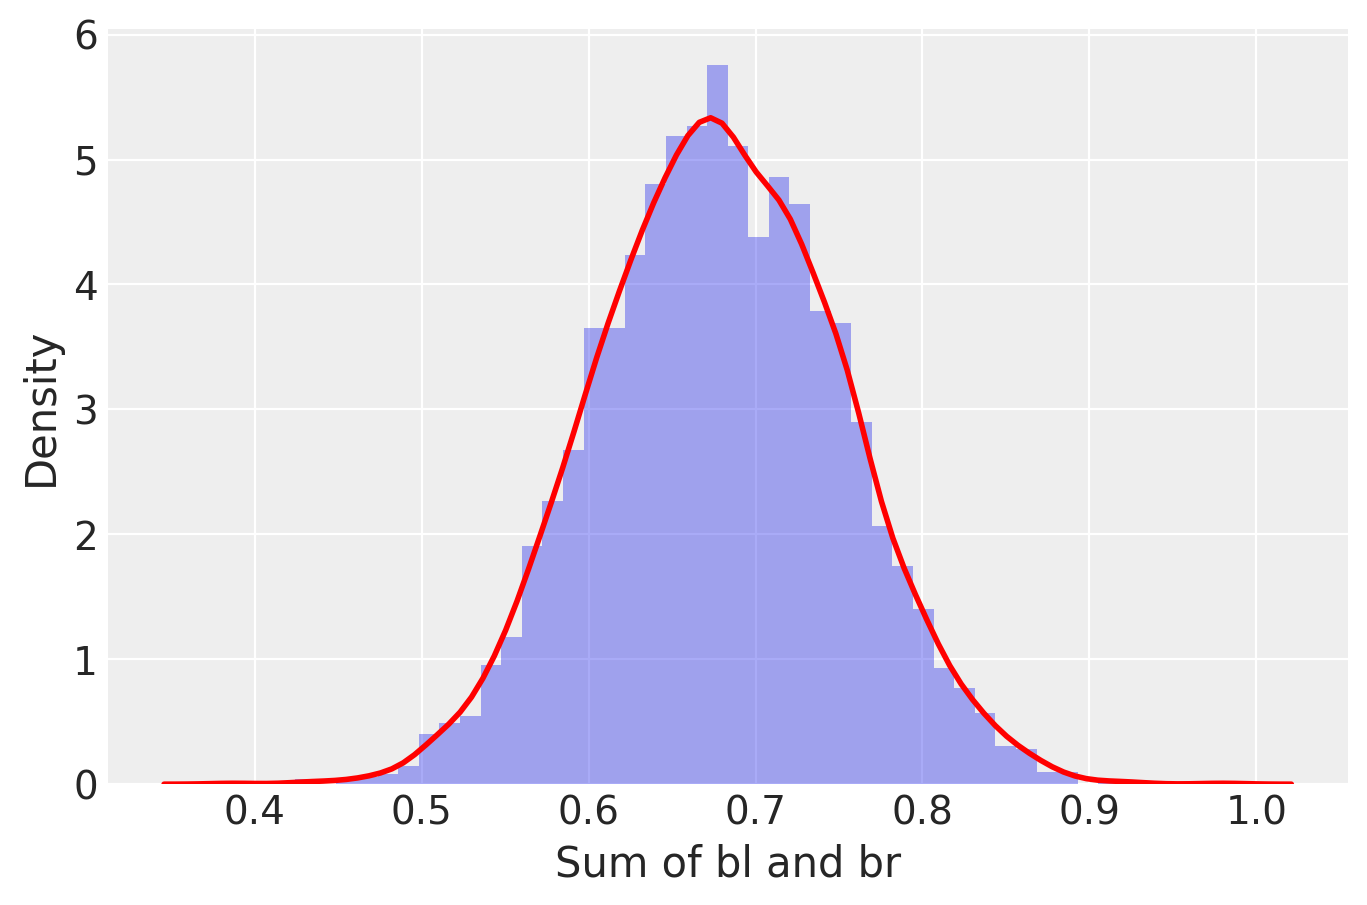

In [11]:
# plot figure
fig = plt.figure(figsize=(8, 5))
sns.distplot(m6_1_trace['br']+m6_1_trace['bl'], hist = True, kde = True, kde_kws = {'linewidth': 2, 'color': 'r'})
plt.xlabel('Sum of bl and br', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.show()

### Code 6.7

In [12]:
# define model: height ~ leg_left
with pm.Model() as m6_2:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bl*df['Leg_Left'])
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df['Height'])
    m6_2_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bl, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2097.91draws/s]


In [13]:
# show model summary
varnames = ['~mu']
az.summary(m6_2_trace, varnames, kind="stats", round_to=2)

,mean,sd,hpd_3%,hpd_97%
a,5.70,0.48,4.72,6.52
bl,0.68,0.07,0.54,0.81
sigma,1.46,0.11,1.26,1.65


### When two predictor variables are very strongly correlated, including both in a model may lead to confusion. 

### 6.1.2. Multicollinear milk

### Code 6.8

In [14]:
# load milk data
d = pd.read_csv("Data/milk.csv", sep=";", header=0)
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [15]:
# standardize data
d["K"] = (d["kcal.per.g"]-d["kcal.per.g"].mean())/d["kcal.per.g"].std()
d["F"] = (d["perc.fat"]-d["perc.fat"].mean())/d["perc.fat"].std()
d["L"] = (np.log(d["perc.lactose"])-np.log(d["perc.lactose"]).mean())/np.log(d["perc.lactose"]).std()
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-1.217243,1.209782
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,-1.030355,0.995003
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,-1.391531,1.262409
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,-1.335535,1.400940
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,-0.469693,0.377224


### Code 6.9

In [16]:
# define model: kcal.per.g regressed on perc.fat
with pm.Model() as m6_3:
    a = pm.Normal('a', mu=0, sd=0.2)
    bF = pm.Normal('bF', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bF*d['F'])
    K = pm.Normal('K', mu=mu, sd=sigma, observed=d['K'])
    m6_3_trace = pm.sample(1000, tune=1000)

# show model summary
varnames = ['~mu']
az.summary(m6_3_trace, varnames, kind="stats", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3562.58draws/s]


,mean,sd,hpd_3%,hpd_97%
a,0.00,0.09,-0.16,0.16
bF,0.86,0.09,0.69,1.03
sigma,0.49,0.07,0.36,0.61


In [17]:
# define model: kcal.per.g regressed on perc.lactose
with pm.Model() as m6_4:
    a = pm.Normal('a', mu=0, sd=0.2)
    bL = pm.Normal('bL', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bL*d['L'])
    K = pm.Normal('K', mu=mu, sd=sigma, observed=d['K'])
    m6_4_trace = pm.sample(1000, tune=1000)

# show model summary
varnames = ['~mu']
az.summary(m6_4_trace, varnames, kind="stats", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bL, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3790.98draws/s]


,mean,sd,hpd_3%,hpd_97%
a,0.00,0.06,-0.11,0.12
bL,-0.93,0.06,-1.04,-0.80
sigma,0.34,0.05,0.26,0.44


### Code 6.10

In [18]:
# define model: kcal.per.g regressed on perc.lactose + perc.fat
with pm.Model() as m6_5:
    a = pm.Normal('a', mu=0, sd=0.2)
    bL = pm.Normal('bL', mu=0, sd=0.5)
    bF = pm.Normal('bF', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bF*d['F'] + bL*d['L'])
    K = pm.Normal('K', mu=mu, sd=sigma, observed=d['K'])
    m6_5_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, bL, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1942.85draws/s]
The acceptance probability does not match the target. It is 0.8956987192780032, but should be close to 0.8. Try to increase the number of tuning steps.


In [19]:
# show model summary
varnames = ['~mu']
az.summary(m6_5_trace, varnames, kind="stats", round_to=2)

,mean,sd,hpd_3%,hpd_97%
a,0.00,0.06,-0.11,0.12
bL,-0.81,0.17,-1.11,-0.50
bF,0.13,0.17,-0.16,0.47
sigma,0.35,0.05,0.26,0.43


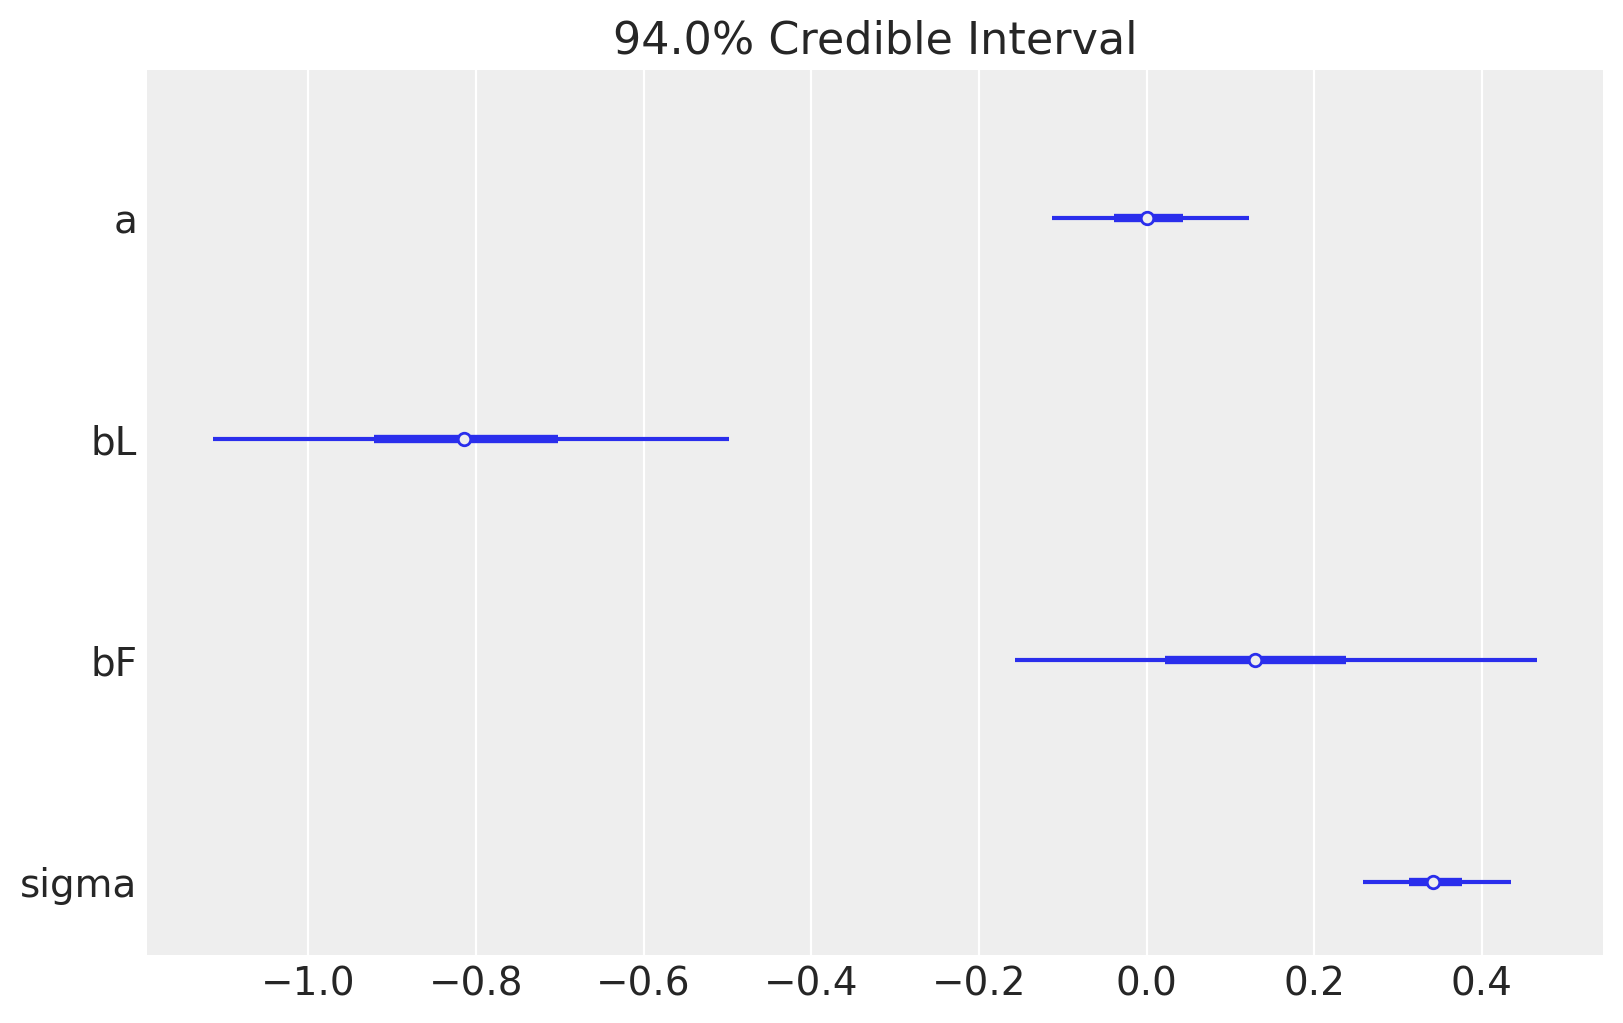

In [20]:
# plot results
axes = az.plot_forest(
    m6_5_trace,
    kind='forestplot',
    var_names=['a','bL','bF','sigma'],
    combined=True,
    ridgeplot_overlap=3,
    credible_interval=0.94,
    figsize=(8, 5))

### Code 6.11

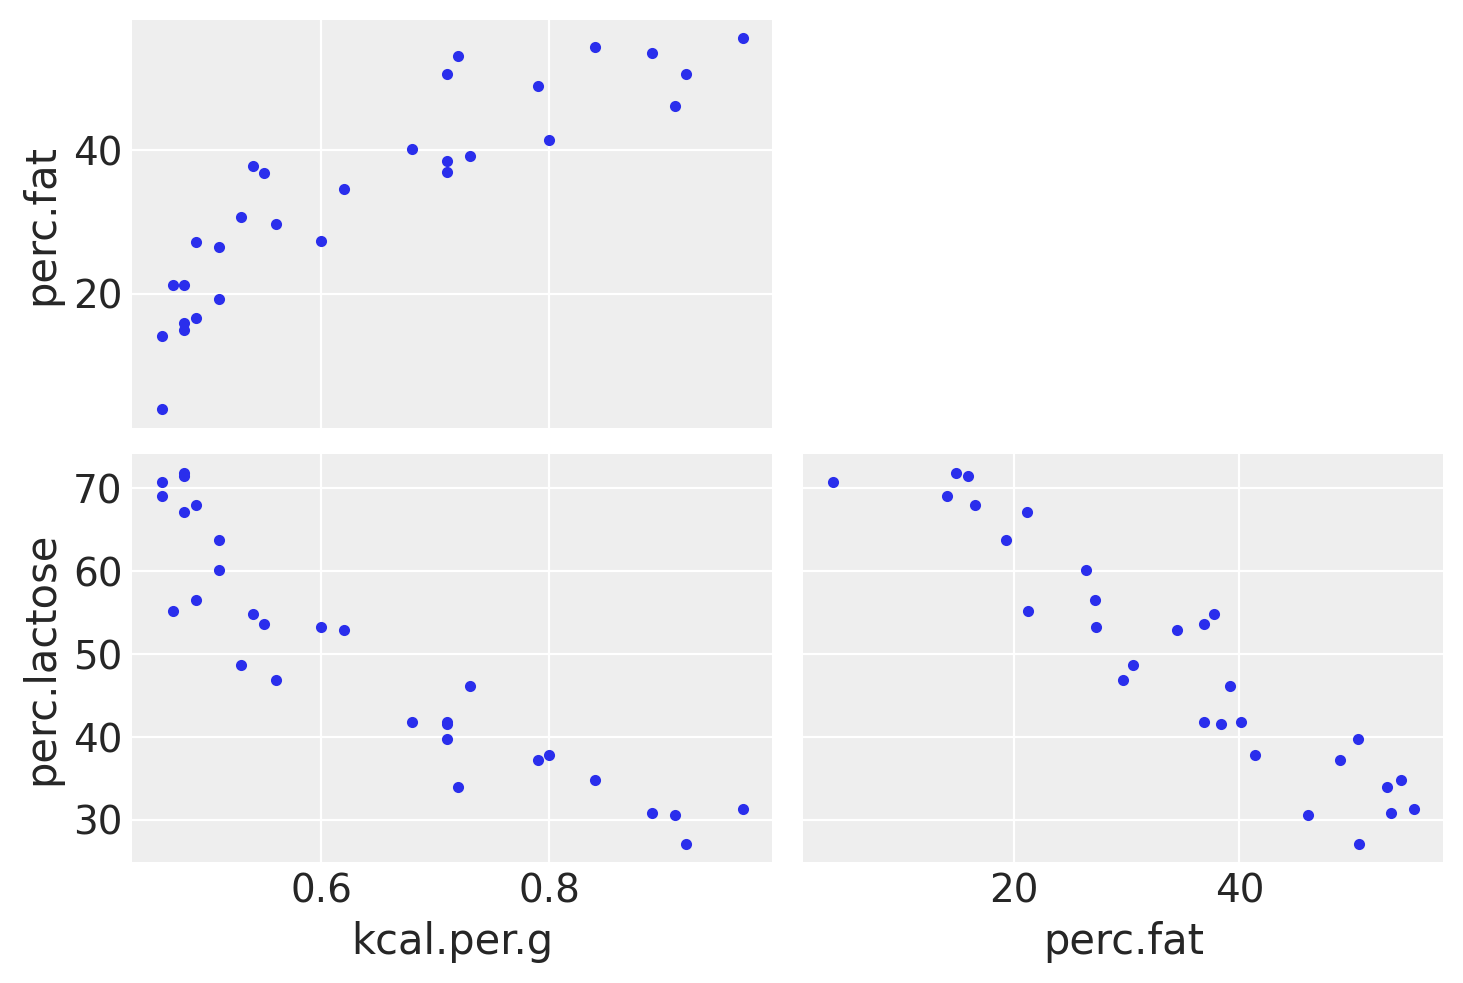

In [21]:
az.plot_pair({"kcal.per.g":d["kcal.per.g"], 
              "perc.fat":d["perc.fat"], 
              "perc.lactose":d["perc.lactose"]})
plt.show()

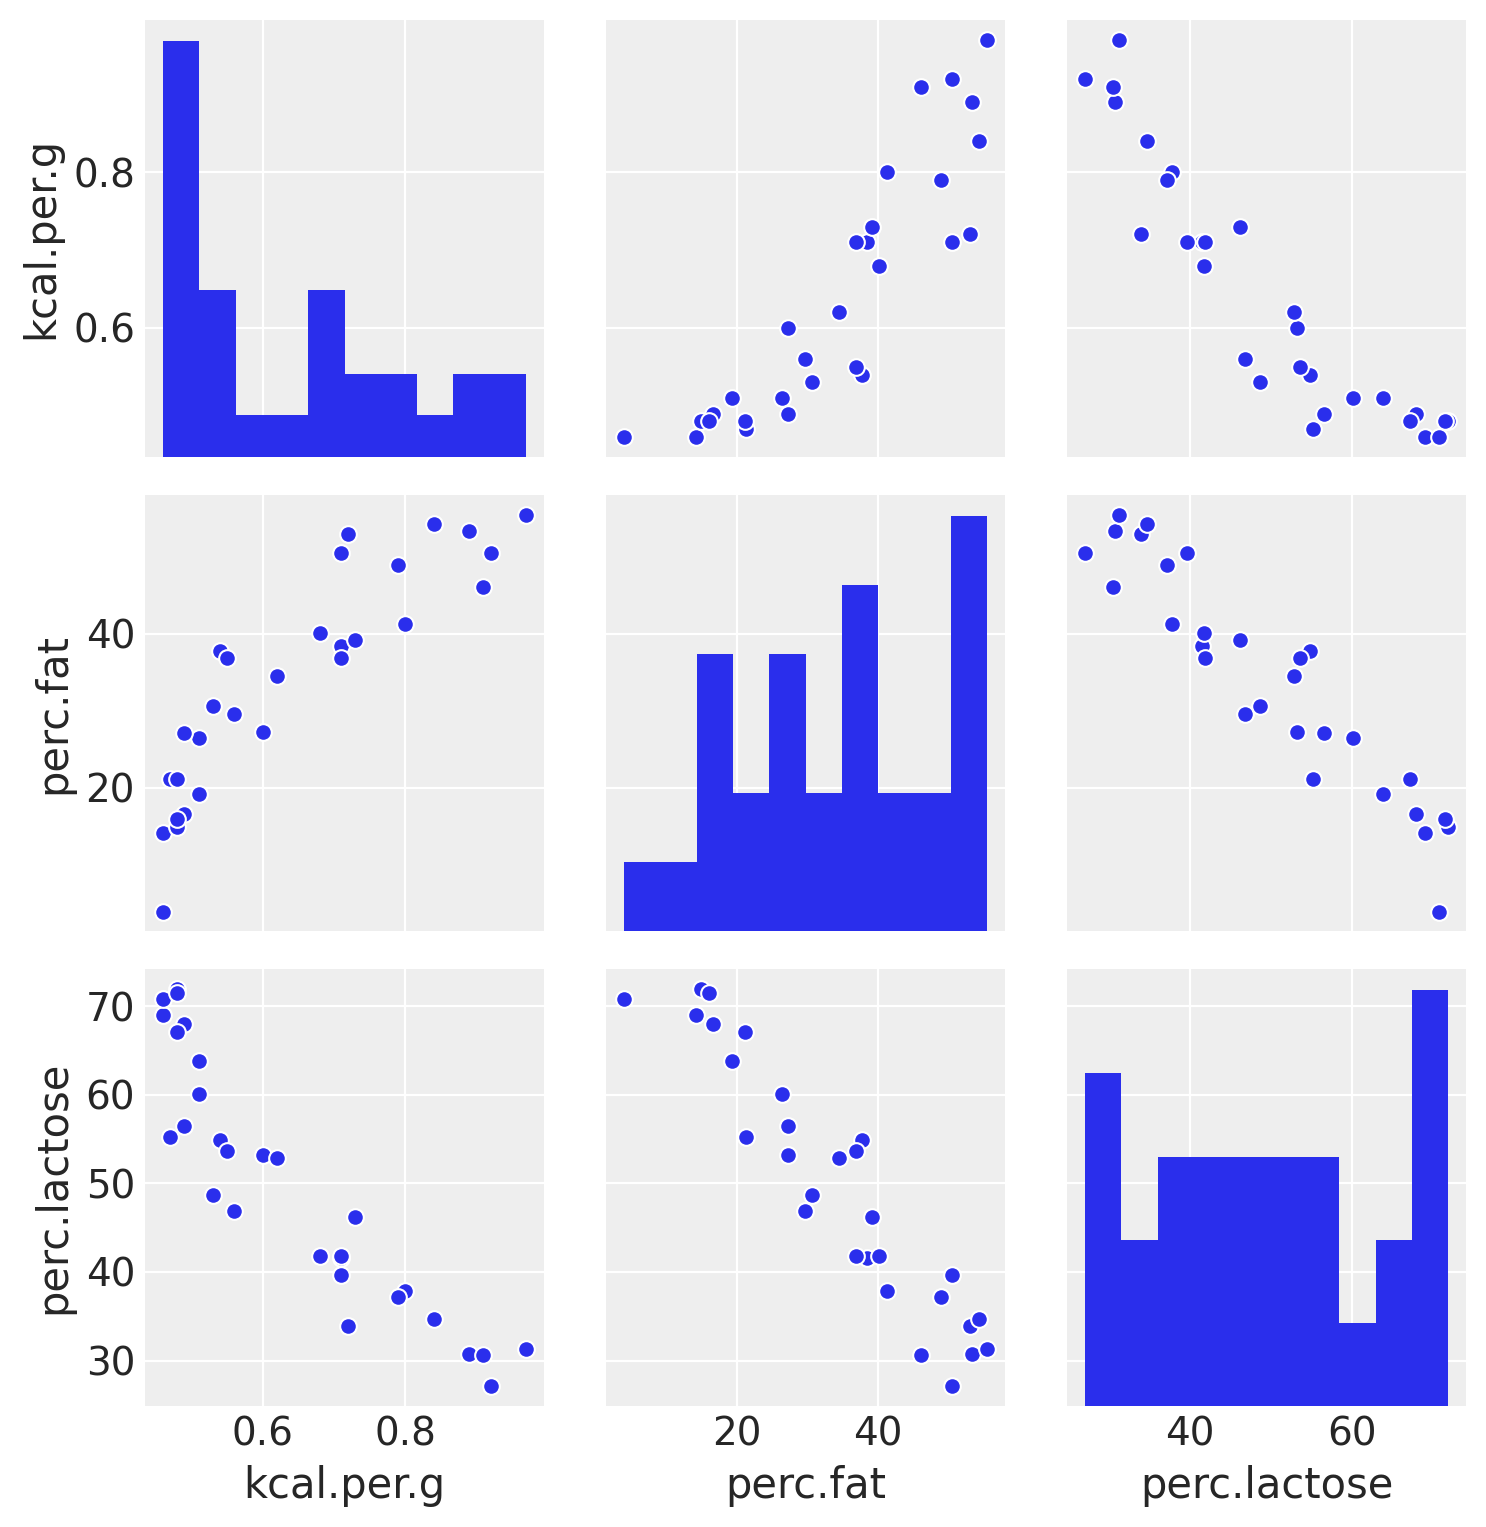

In [22]:
df = d[['kcal.per.g','perc.fat','perc.lactose']]
sns.pairplot(df)
plt.show()

In [23]:
d.corr()['perc.fat']['perc.lactose']

-0.9416373456839282

### Code 6.12

Figure is missing.

## 6.2. Post-treatment bias

### Code 6.13

In [24]:
# number of plants
N = 100
# simulate initial heights
h0 = stats.norm.rvs(size=N, loc=10, scale=2)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = np.random.binomial(n=1, p=(0.5-treatment*0.4), size=N)
h1 = h0 + stats.norm.rvs(size=N, loc= 5-3*fungus, scale=1)
# compose a clean data frame
d = pd.DataFrame({'h0': h0,
                  'h1': h1,
                  'Treatment':treatment,
                  'Fungus': fungus})
d.head()

,h0,h1,Treatment,Fungus
0,9.455919,9.769840,0,1
1,11.489513,15.707239,0,0
2,9.792919,12.145858,0,1
3,8.807844,11.783516,0,1
4,13.974254,15.466161,0,1


### 6.2.1. A prior is born

### Code 6.14

In [25]:
sim_p = stats.lognorm.rvs(s=0.25, size=10000)
az.summary(sim_p, kind="stats", round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
x,1.04,0.26,0.62,1.41


### Code 6.15

In [26]:
# define model: height ~ growth_p
with pm.Model() as m6_6:
    p = pm.Lognormal('p', mu=0, sigma=0.25)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', p*d['h0'])
    h1 = pm.Normal('h1', mu=mu, sd=sigma, observed=d['h1'])
    m6_6_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4046.52draws/s]


In [27]:
# show model summary
varnames = ['~mu']
az.summary(m6_6_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
p,1.42,0.02,1.39,1.45
sigma,1.92,0.14,1.70,2.13


### Code 6.16

In [28]:
# define model: height ~ growth_p(treatment and fungus) 
with pm.Model() as m6_7: 
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    bT = pm.Normal('bT', mu=0, sd=0.5)
    bF = pm.Normal('bF', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', 1)
    p = pm.Deterministic('p', a + bT*d['Treatment'] + bF*d['Fungus'])
    mu = pm.Deterministic('mu', p*d['h0'])
    h1 = pm.Normal('h1', mu=mu, sd=sigma, observed=d['h1'])
    m6_7_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, bT, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2515.41draws/s]


In [29]:
# show model summary
varnames = ['~mu','~p']
az.summary(m6_7_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
bT,-0.00,0.03,-0.05,0.06
bF,-0.30,0.04,-0.35,-0.23
a,1.50,0.03,1.46,1.55
sigma,1.41,0.10,1.26,1.57


### 6.2.2. Blocked by consequence

### Code 6.17

In [30]:
# define model: height ~ growth_p(treatment) 
with pm.Model() as m6_8: 
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    bT = pm.Normal('bT', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', 1)
    p = pm.Deterministic('p', a + bT*d['Treatment'])
    mu = pm.Deterministic('mu', p*d['h0'])
    h1 = pm.Normal('h1', mu=mu, sd=sigma, observed=d['h1'])
    m6_8_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bT, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2992.00draws/s]


In [31]:
# show model summary
varnames = ['~mu','~p']
az.summary(m6_8_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
bT,0.13,0.04,0.07,0.19
a,1.36,0.03,1.32,1.40
sigma,1.81,0.13,1.60,2.01


It is much less routine to worry about mistaken inferences arising from including variables that are consequences of other variables. It makes sense to control for pre-treatment differences, like the initial height h0, that might mask the causal influence of treatment. But including post-treatment variables can actually mask the treatment itself.

### 6.2.3. Fungus and $d$-separation

### Code 6.18 and Code 6.19

Drawing a DAG Visit http://www.dagitty.net/.

### $d$-separation. The “d” stands for directional. $d$-separation means that some variables on a directed graph are independent of others. 

### Code 6.20

In [32]:
# number of plants
N = 1000
# simulate initial heights
h0 = stats.norm.rvs(size=N, loc=10, scale=2)
# assign treatments and simulate fungus and growth
M = stats.bernoulli.rvs(p=0.5, size=N)
treatment = np.repeat([0, 1], [N/2]*2)
fungus = np.random.binomial(n=1, p=(0.5-treatment*0.4+0.4*M), size=N)
h1 = h0 + stats.norm.rvs(size=N, loc= 5+3*M, scale=1)
# compose a clean data frame
d = pd.DataFrame({'h0': h0,
                  'h1': h1,
                  'Treatment':treatment,
                  'Fungus': fungus})
d.head()

,h0,h1,Treatment,Fungus
0,8.575415,17.719515,0,1
1,13.285340,18.559723,0,1
2,8.712505,12.952676,0,1
3,10.612216,16.338597,0,1
4,9.482627,17.142368,0,1


In [33]:
# define model: height ~ growth_p(treatment and fungus) 
with pm.Model() as m6_7: 
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    bT = pm.Normal('bT', mu=0, sd=0.5)
    bF = pm.Normal('bF', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', 1)
    p = pm.Deterministic('p', a + bT*d['Treatment'] + bF*d['Fungus'])
    mu = pm.Deterministic('mu', p*d['h0'])
    h1 = pm.Normal('h1', mu=mu, sd=sigma, observed=d['h1'])
    m6_7_trace = pm.sample(1000, tune=1000)
    
# show model summary
varnames = ['~mu','~p']
az.summary(m6_7_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, bT, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2033.47draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
bT,0.06,0.01,0.03,0.08
bF,0.14,0.01,0.11,0.16
a,1.52,0.01,1.50,1.54
sigma,2.08,0.05,2.01,2.15


In [34]:
# define model: height ~ growth_p(treatment) 
with pm.Model() as m6_8: 
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    bT = pm.Normal('bT', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', 1)
    p = pm.Deterministic('p', a + bT*d['Treatment'])
    mu = pm.Deterministic('mu', p*d['h0'])
    h1 = pm.Normal('h1', mu=mu, sd=sigma, observed=d['h1'])
    m6_8_trace = pm.sample(1000, tune=1000)
    
# show model summary
varnames = ['~mu','~p']
az.summary(m6_8_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bT, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2760.42draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
bT,0.01,0.01,-0.02,0.03
a,1.61,0.01,1.60,1.63
sigma,2.18,0.05,2.11,2.26


## 6.3. Collider bias

### 6.3.1. Collider of false sorrow

Simulations on Happiness (H) and age (A) both cause marriage (M)

1. Each year, 20 people are born with uniformly distributed happiness values.
2. Each year, each person ages one year. Happiness does not change.
3. At age 18, individuals can become married. The odds of marriage each year are proportional to an individual’s happiness.
4. Once married, an individual remains married.
5. After age 65, individuals leave the sample. (They move to Spain.)

### Code 6.21

In [35]:
def sim_happiness(N_years=1000, max_age=65, N_births=20, aom=18):
    H=[0]
    M=[0]
    A=[0]
    for t in range(N_years):
        # age existing individuals
        A = [x + 1 for x in A]
        # newborns
        A = A + np.repeat(1, N_births).tolist()
        # sim happiness trait - never changes
        H = H + np.linspace(-2, 2, N_births).tolist()
        # not yet married
        M = M + np.repeat(0, N_births).tolist()
        # for each person over 17, chance get married
        for i in range(len(A)):
            if A[i]>=aom and M[i]==0:
                M[i] = int(np.random.binomial(n=1, p=special.expit(H[i]-4), size=1))
        # mortality
        deaths = []
        for i in range(len(A)):
            if A[i]>max_age:
                deaths.append(i)
        A = [x for i,x in enumerate(A) if i not in deaths]
        H = [x for i,x in enumerate(H) if i not in deaths]
        M = [x for i,x in enumerate(M) if i not in deaths]
        #print(A)
        #print(M)
    # compose a clean data frame
    d = pd.DataFrame({'age': A,
                      'married': M,
                      'happiness':H})
    return d

In [36]:
d = sim_happiness()
d.describe()

,age,married,happiness
count,1300.000000,1300.000000,1.300000e+03
mean,33.000000,0.280000,-8.335213e-17
std,18.768883,0.449172,1.214421e+00
min,1.000000,0.000000,-2.000000e+00
25%,17.000000,0.000000,-1.000000e+00
50%,33.000000,0.000000,-1.110223e-16
75%,49.000000,1.000000,1.000000e+00
max,65.000000,1.000000,2.000000e+00


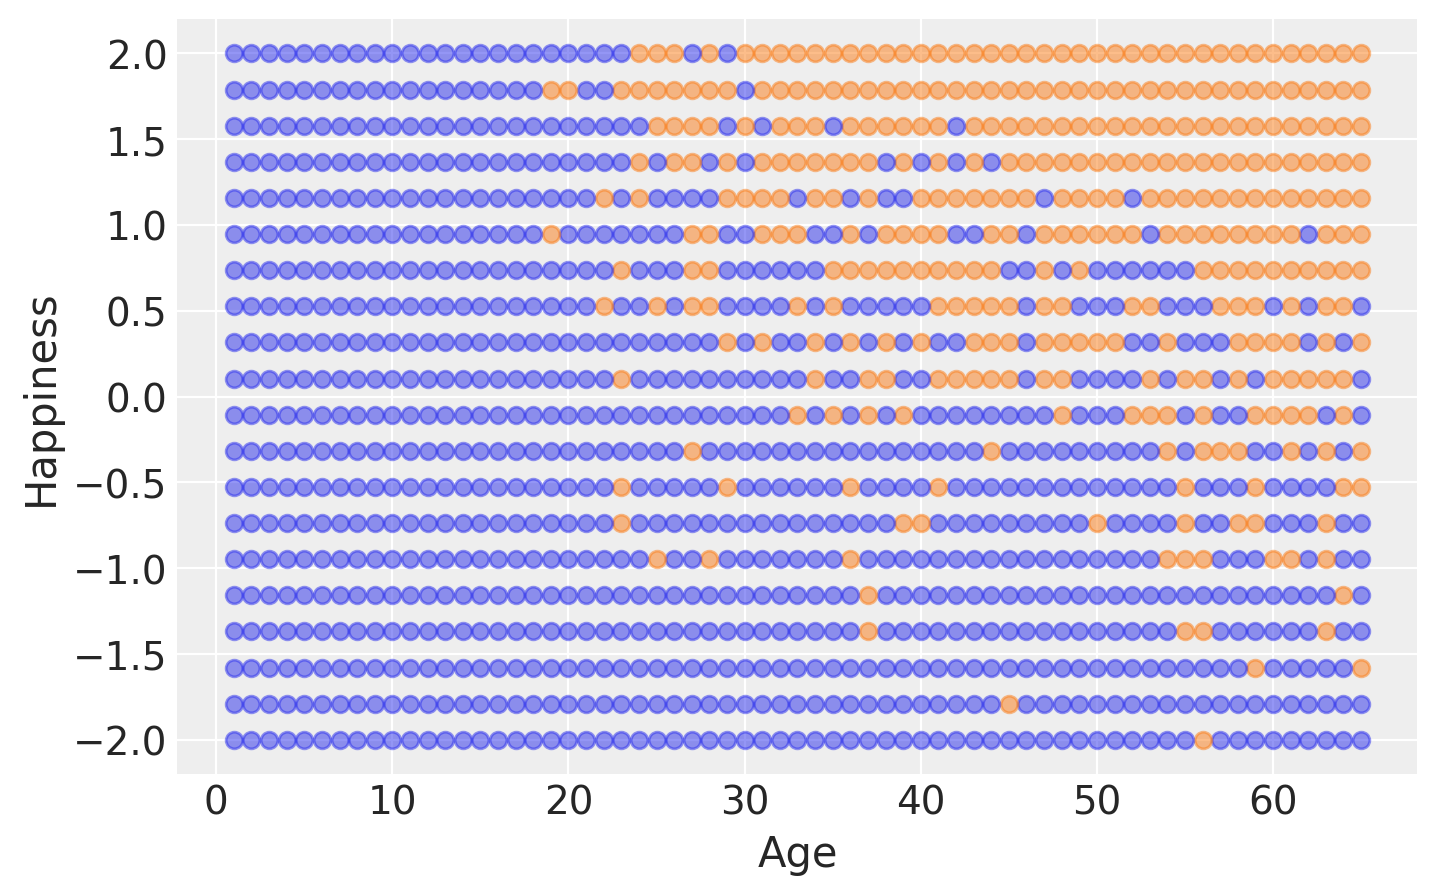

In [37]:
# plot results
fig = plt.figure(figsize=(8, 5))
for i in range(len(d)):
    if d['married'][i]==1:
        plt.plot(d['age'][i], d['happiness'][i], 'C1o', alpha=0.5)
    else:
        plt.plot(d['age'][i], d['happiness'][i], 'C0o', alpha=0.5)  
plt.ylabel('Happiness', fontsize=15)
plt.xlabel('Age', fontsize=15)
plt.show()

### Code 6.22

In [38]:
# filter out people < 17
d2 = d[d.age>17]
d2['A'] = (d2['age']-18)/(65-18)
d2.head()

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,age,married,happiness,A
0,65,0,-2.000000,1.0
1,65,0,-1.789474,1.0
2,65,1,-1.578947,1.0
3,65,0,-1.368421,1.0
4,65,0,-1.157895,1.0


### Code 6.23

In [39]:
mid = d2['married'].values
# define model: influence of age on happiness, while controlling for marriage status.
# μ_i = α_mid[i] + β_A*A_i
with pm.Model() as m6_9:
    a = pm.Normal('a', mu=0, sd=2, shape=2)
    bA = pm.Normal('bA', mu=0, sd=2)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a[mid] + bA*d2['A'])
    happiness = pm.Normal('happiness', mu=mu, sd=sigma, observed=d2['happiness'])
    m6_9_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2040.11draws/s]


In [40]:
# show model summary
varnames = ['~mu']
az.summary(m6_9_trace, varnames, kind="stats", round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a[0],-0.22,0.06,-0.31,-0.12
a[1],1.39,0.09,1.25,1.53
bA,-0.78,0.11,-0.95,-0.60
sigma,0.96,0.02,0.92,0.99


### Code 6.24


In [41]:
# define model: influence of age on happiness without controlling for marriage status.
# μ_i = α + β_A*A_i
with pm.Model() as m6_10:
    a = pm.Normal('a', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=2)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bA*d2['A'])
    happiness = pm.Normal('happiness', mu=mu, sd=sigma, observed=d2['happiness'])
    m6_10_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2577.23draws/s]


In [42]:
# show model summary
varnames = ['~mu']
az.summary(m6_10_trace, varnames, kind="stats", round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.00,0.08,-0.12,0.12
bA,-0.00,0.13,-0.22,0.20
sigma,1.22,0.03,1.17,1.26


### 6.3.2. The haunted DAG

### Code 6.25

DAG above implies that:
1. P is some function of G and U
2. C is some function of G, P, and U
3. G and U are not functions of any other known variables

In [43]:
N = 200  # number of grandparent-parent-child triads
b_GP = 1 # direct effect of G on P
b_GC = 0 # direct effect of G on C
b_PC = 1 # direct effect of P on C
b_U = 2  # direct effect of U on P and C

### Code 6.26

In [44]:
U = 2*stats.bernoulli.rvs(p=0.5, size=N)-1
G = stats.norm().rvs(N)
P = stats.norm(b_GP*G + b_U*U).rvs(N)
C = stats.norm(b_PC*P + b_GC*G + b_U*U).rvs(N)
d = pd.DataFrame({'C': C,
                  'P': P,
                  'G': G,
                  'U': U})
d.head()

,C,P,G,U
0,4.322428,1.511198,-1.232283,1
1,5.537550,3.518811,0.937737,1
2,-3.817229,-2.847341,-1.284254,-1
3,-6.095934,-3.545080,-0.283546,-1
4,3.467487,1.668003,-0.541789,1


In [45]:
# define model: regression of C on P and G
with pm.Model() as m6_11:
    a = pm.Normal('a', mu=0, sd=1)
    b_PC = pm.Normal('b_PC', mu=0, sd=1)
    b_GC = pm.Normal('b_GC', mu=0, sd=1)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + b_PC*d['P'] + b_GC*d['G'])
    C = pm.Normal('C', mu=mu, sd=sigma, observed=d['C'])
    m6_11_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_GC, b_PC, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3060.20draws/s]


In [46]:
# show model summary
varnames = ['~mu']
az.summary(m6_11_trace, varnames, kind="stats", round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.12,0.10,-0.03,0.29
b_PC,1.81,0.05,1.74,1.89
b_GC,-0.87,0.11,-1.06,-0.70
sigma,1.46,0.07,1.34,1.57


### Figure 6.5

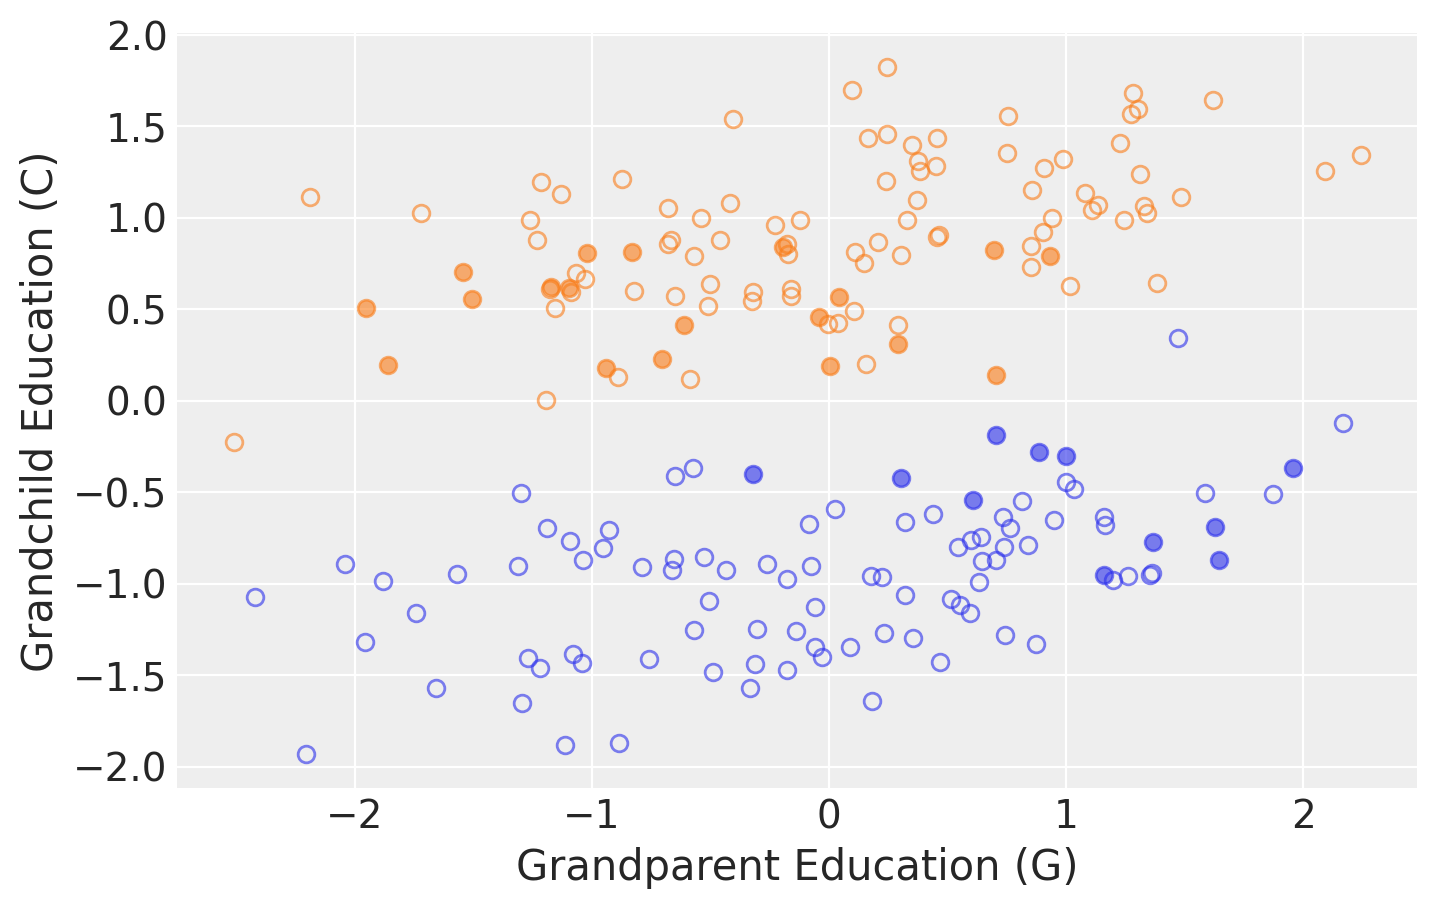

In [47]:
d['G_std'] = (d['G']-d['G'].mean())/d['G'].std()
d['C_std'] = (d['C']-d['C'].mean())/d['C'].std()
P_per = np.percentile(d['P'],[45, 60])
# plot results
fig = plt.figure(figsize=(8, 5))
for i in range(len(d)):
    if d['U'][i]==1:
        if d['P'][i]>P_per[0] and d['P'][i]<P_per[1]:
            plt.plot(d['G_std'][i], d['C_std'][i], 'C1o', alpha=0.6, fillstyle='full')
        else:
            plt.plot(d['G_std'][i], d['C_std'][i], 'C1o', alpha=0.6, fillstyle='none')
    else:
        if d['P'][i]>P_per[0] and d['P'][i]<P_per[1]:
            plt.plot(d['G_std'][i], d['C_std'][i], 'C0o', alpha=0.6, fillstyle='full') 
        else:
            plt.plot(d['G_std'][i], d['C_std'][i], 'C0o', alpha=0.6, fillstyle='none')  
plt.ylabel('Grandchild Education (C)', fontsize=15)
plt.xlabel('Grandparent Education (G)', fontsize=15)
plt.show()

### Code 6.28

In [48]:
# define model: regression of C on P and G and U
with pm.Model() as m6_12:
    a = pm.Normal('a', mu=0, sd=1)
    b_PC = pm.Normal('b_PC', mu=0, sd=1)
    b_GC = pm.Normal('b_GC', mu=0, sd=1)
    b_U = pm.Normal('b_U', mu=0, sd=1)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + b_PC*d['P'] + b_GC*d['G'] + b_U*d['U'])
    C = pm.Normal('C', mu=mu, sd=sigma, observed=d['C'])
    m6_12_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_U, b_GC, b_PC, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1808.43draws/s]


In [49]:
# show model summary
varnames = ['~mu']
az.summary(m6_12_trace, varnames, kind="stats", round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.01,0.08,-0.11,0.15
b_PC,1.05,0.07,0.94,1.17
b_GC,-0.14,0.11,-0.31,0.03
b_U,1.91,0.16,1.66,2.17
sigma,1.10,0.06,1.01,1.19


## 6.4. Confronting confounding

**Confounding** as any context in which the association between an outcome Y and a predictor of interest X is not the same as it would be, if we had experimentally determined the values of X.

### 6.4.1. Shutting the backdoor

1. The first type of relation is the one we worked with just above, a **fork**: X←Z→Y. This is the classic confounder. In a fork, some variable Z is a common cause of X and Y, generating a correlation between them. If we condition on Z, then learning X tells us nothing about Y. X and Y are independent, conditional on Z.

2. The second type of relation is a **pipe**: X → Z → Y. We saw this when we discussed the plant growth example and post-treatment bias: The treatment X influences fungus Z which influences growth Y. If we condition on Z now, we also block the path from X to Y. So in both a fork and a pipe, conditioning of the middle variable blocks the path.

3. The third type of relation is a **collider**: X → Z ← Y. You met colliders earlier in this chapter. Unlike the other two types of relations, in a collider there is no association between X and Y unless you condition on Z. Conditioning on Z, the collider variable, opens the path. Once the path is open, information flows between X and Y.

4. The fourth bit of knowledge you need is that conditioning on a **descendent** variable is like conditioning on the variable itself, but weaker. A descendent is a variable influenced by another variable. 


### 6.4.2. Two roads

### Code 6.29

Drawing a DAG Visit http://www.dagitty.net/.

### 6.4.3. Backdoor waffles

### Code 6.30 and Code 6.31


Drawing a DAG Visit http://www.dagitty.net/.

### Referece

[pymc-devs: Rethinking_1 Chp05](https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_05.ipynbb)